In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import tree
from collections import defaultdict
import random
import pydot
from io import StringIO
import pydotplus

In [413]:
df = pd.read_csv('movie_metadata.csv').dropna()

In [414]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [415]:
dataset = df[['gross', 'imdb_score', 'movie_title']]
print(len(dataset))
dataset = dataset.values.tolist()

3756


In [416]:
def kMedoids(data, k, prev_cost, count, clusters=None, medoids=None):

    cluster_sum = 0
    random.seed(0)

    while True:

        if medoids is None or not medoids:
            medoids = random.sample(data, k)
        else:
            random.shuffle(medoids)
            for _ in range(0, int(k/2)):
                medoids.pop()
            medoids += random.sample(data, int(k/2))

        clusters = defaultdict(list)

        for item in data:
            temp = []
            for i in range(0, len(medoids)):
                med = medoids[i]
                if med is None or not med:
                    break
                else:
                    temp.append(np.linalg.norm(
                        med[0]-item[0])+np.linalg.norm(med[1]-item[1]))
            min_index = np.argmin(temp)
            clusters[min_index].append(item)

        for i in range(0, len(medoids)):
            inter_cluster = clusters[i]
            for j in range(0, len(inter_cluster)):
                item_cluster = inter_cluster[j]
                medoid = medoids[i]
                cluster_sum += (np.linalg.norm(medoid[0]-item_cluster[0]) +
                                np.linalg.norm(medoid[1]-item_cluster[1]))

        if cluster_sum < prev_cost:
            prev_cost = cluster_sum
        else:
            break

        count += 1

    return clusters

In [417]:
clusters = kMedoids(dataset, 5, np.inf, 0)
for i in range(0,len(clusters)):
    print(str(i+1),len(clusters.get(i)))

1 198
2 250
3 807
4 2013
5 488


No handles with labels found to put in legend.


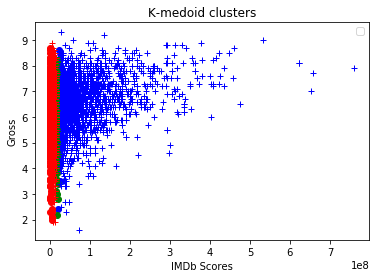

In [418]:
def plot_graph(clusters):
    markers = ['bo', 'go', 'ro', 'b+', 'r+', 'g+']
    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            plt.plot(df[0], df[1], markers[i])
    plt.xlabel('IMDb Scores')
    plt.ylabel('Gross')
    plt.title('K-medoid clusters')
    plt.legend()
    plt.show()

plot_graph(clusters)

In [419]:
columns = ['num_user_for_reviews', 'budget'
               , 'num_critic_for_reviews', 'movie_title','movie_facebook_likes','num_voted_users','duration']

df = df[columns]

In [420]:
def assign_target(row, clusters):

    x = row['movie_title']

    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            if df[2] == x:
                row['cluster'] = 'cluster'+str(i)

    return row

In [421]:
df = df.reset_index()
df = df.apply(assign_target, args=(clusters,), axis=1)
df.drop(labels = ['movie_title'], axis = 1, inplace = True)
print(df.tail())

      index  num_user_for_reviews   budget  num_critic_for_reviews  \
3751   5026                  39.0   4500.0                    81.0   
3752   5027                  26.0  10000.0                    64.0   
3753   5033                 371.0   7000.0                   143.0   
3754   5035                 130.0   7000.0                    56.0   
3755   5042                  84.0   1100.0                    43.0   

      movie_facebook_likes  num_voted_users  duration   cluster  
3751                   171             3924     110.0  cluster2  
3752                   697             4555      90.0  cluster2  
3753                 19000            72639      77.0  cluster2  
3754                     0            52055      81.0  cluster2  
3755                   456             4285      90.0  cluster2  


In [422]:
df_before_split = df.copy()
print(df.head())
splitSet = StratifiedShuffleSplit(
        n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in splitSet.split(df, df['cluster']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

Y_train = train_set.cluster
X_train = train_set[train_set.columns.drop('cluster').drop('index')]
Y_test = test_set.cluster
X_test = test_set[test_set.columns.drop('cluster').drop('index')]

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

predictions = decision_tree.predict(X_test)

   index  num_user_for_reviews       budget  num_critic_for_reviews  \
0      0                3054.0  237000000.0                   723.0   
1      1                1238.0  300000000.0                   302.0   
2      2                 994.0  245000000.0                   602.0   
3      3                2701.0  250000000.0                   813.0   
4      5                 738.0  263700000.0                   462.0   

   movie_facebook_likes  num_voted_users  duration   cluster  
0                 33000           886204     178.0  cluster3  
1                     0           471220     169.0  cluster3  
2                 85000           275868     148.0  cluster3  
3                164000          1144337     164.0  cluster3  
4                 24000           212204     132.0  cluster3  


In [423]:
print('Accuracy', decision_tree.score(X_test, Y_test))

Accuracy 0.5678191489361702


In [424]:
print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[  6   3   6  18   7]
 [  2   4  12  16  16]
 [  9  10  96  20  26]
 [ 22  29  25 295  32]
 [ 12   7  23  30  26]]


             precision    recall  f1-score   support

   cluster0       0.12      0.15      0.13        40
   cluster1       0.08      0.08      0.08        50
   cluster2       0.59      0.60      0.59       161
   cluster3       0.78      0.73      0.75       403
   cluster4       0.24      0.27      0.25        98

avg / total       0.59      0.57      0.58       752



In [425]:
rfc = RandomForestClassifier(n_estimators=2000)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [426]:
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test,rfc_pred))
print('\n')
print(classification_report(Y_test,rfc_pred))

[[  2   1   7  20  10]
 [  0   1  16  24   9]
 [  0   0 120  24  17]
 [  1   7  16 365  14]
 [  0   2  29  44  23]]


             precision    recall  f1-score   support

   cluster0       0.67      0.05      0.09        40
   cluster1       0.09      0.02      0.03        50
   cluster2       0.64      0.75      0.69       161
   cluster3       0.77      0.91      0.83       403
   cluster4       0.32      0.23      0.27        98

avg / total       0.63      0.68      0.63       752



In [427]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, impurity=False, feature_names=train_set.columns.drop('cluster').drop('index'))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("dtree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.497843 to fit



True